In [13]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [25]:
import pandas as pd
import seaborn as sns
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

In [15]:
data = pd.read_csv('../data/hackathon_processed.csv')
data

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,1815.0,JURASSIC,LIMESTONE,75.0,55.2,21.0,410.0
1,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,ONSHORE,GAS-CONDENSATE,MATURE PRODUCTION,RIFT,3084.6,CRETACEOUS,SANDSTONE,223.5,43.2,10.0,8.0
2,ABU MADI-EL QARA,ABU MADI (LEVEL II),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH,2952.9,NEOGENE,THINLY-BEDDED SANDSTONE,34.5,19.8,22.0,200.0
3,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH,3149.7,NEOGENE,SANDSTONE,152.7,123.0,20.0,300.0
4,AL HUWAISAH,SHUAIBA,OMAN,MIDDLE EAST,FAHUD SALT,COMPRESSION,21.9607,56.0452,PDO,ONSHORE,OIL,REJUVENATING,SALT,1486.5,CRETACEOUS,LIMESTONE,75.0,30.0,21.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,ZAOYUAN,KONGDIAN-1 (ZILAITUN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,OIL,DECLINING PRODUCTION,RIFT,1416.3,PALEOGENE,SANDSTONE,49.2,18.6,23.2,121.0
510,ZAOYUAN,KONGDIAN-2 (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,NaN,38.2100,117.0600,PETROCHINA,ONSHORE,OIL,PLATEAU PRODUCTION,RIFT,2273.7,PALEOGENE,SANDSTONE,88.5,23.7,NaN,60.0
511,ZAOYUAN,UNNAMED (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,OIL,MATURE PRODUCTION,RIFT,2952.9,MESOZOIC,VOLCANICS,147.6,58.2,12.7,3.6
512,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,561.0,CARBONIFEROUS,SANDSTONE,78.6,9.9,24.0,30.0


In [16]:
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth
0,COMPRESSION,JURASSIC,LIMESTONE,FORELAND,75.0,55.2,21.0,410.0,1815.0
1,EXTENSION,CRETACEOUS,SANDSTONE,RIFT,223.5,43.2,10.0,8.0,3084.6
2,STRIKE-SLIP,NEOGENE,THINLY-BEDDED SANDSTONE,WRENCH,34.5,19.8,22.0,200.0,2952.9
3,STRIKE-SLIP,NEOGENE,SANDSTONE,WRENCH,152.7,123.0,20.0,300.0,3149.7
4,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,75.0,30.0,21.0,60.0,1486.5
...,...,...,...,...,...,...,...,...,...
437,EXTENSION,PALEOGENE,SANDSTONE,RIFT,69.0,20.7,26.7,1872.0,1615.2
438,EXTENSION,PALEOGENE,SANDSTONE,RIFT,49.2,18.6,23.2,121.0,1416.3
439,EXTENSION,MESOZOIC,VOLCANICS,RIFT,147.6,58.2,12.7,3.6,2952.9
440,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,78.6,9.9,24.0,30.0,561.0


In [17]:
nodes_type = get_nodes_type(data)
nodes_type

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [18]:
nodes_sign = get_nodes_sign(data)
nodes_sign

{'Gross': 'pos',
 'Netpay': 'pos',
 'Porosity': 'pos',
 'Permeability': 'pos',
 'Depth': 'pos'}

In [19]:
coded_data, coder = code_categories(data, 'label', ['Tectonic regime', 'Period', 'Lithology', 'Structural setting'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', ['Gross','Netpay','Porosity','Permeability', 'Depth'])

In [20]:
bn = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
bn

{'V': ['Tectonic regime',
  'Period',
  'Lithology',
  'Structural setting',
  'Gross',
  'Netpay',
  'Porosity',
  'Permeability',
  'Depth'],
 'E': [['Tectonic regime', 'Structural setting'],
  ['Period', 'Porosity'],
  ['Period', 'Gross'],
  ['Lithology', 'Permeability'],
  ['Lithology', 'Gross'],
  ['Structural setting', 'Depth'],
  ['Structural setting', 'Gross'],
  ['Structural setting', 'Period'],
  ['Gross', 'Netpay'],
  ['Porosity', 'Permeability'],
  ['Porosity', 'Depth']]}

In [21]:
draw_BN(bn, nodes_type, 'geo_bn')

In [22]:
params = parameter_learning(data, nodes_type, bn, 'simple')

In [23]:
save_structure(bn, 'geo_net_structure')
skel = read_structure('geo_net_structure')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [24]:
synth_df = generate_synthetics(geo_bn, nodes_sign, 'simple', 800)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Gross', ylabel='Density'>

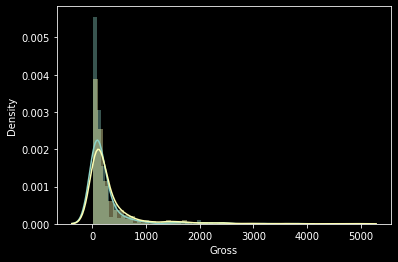

In [26]:
sns.distplot(data['Gross'])
sns.distplot(synth_df['Gross'])

In [27]:
data = pd.read_csv('../data/socio.csv')
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data

,sex,relation,is_parent,has_pets,age,mean_tr,median_tr,tr_per_month
0,1,0,0,0,40,1304.422520,790.000,41.139952
1,2,0,1,0,36,3508.349043,499.000,14.874795
2,2,0,0,0,24,1408.932418,228.950,8.920308
3,1,0,1,0,31,1364.327931,536.575,35.306775
4,1,0,0,0,31,1060.487451,446.000,10.280004
...,...,...,...,...,...,...,...,...
3784,2,7,0,1,25,639.568421,209.300,36.537512
3785,1,7,0,0,30,1380.780718,300.000,10.049458
3786,2,8,0,0,40,938.782985,191.000,43.385687
3787,1,8,1,0,44,573.100453,250.000,52.585775


In [28]:
data['age'] = data['age'].apply(lambda x: float(x))
data

,sex,relation,is_parent,has_pets,age,mean_tr,median_tr,tr_per_month
0,1,0,0,0,40.0,1304.422520,790.000,41.139952
1,2,0,1,0,36.0,3508.349043,499.000,14.874795
2,2,0,0,0,24.0,1408.932418,228.950,8.920308
3,1,0,1,0,31.0,1364.327931,536.575,35.306775
4,1,0,0,0,31.0,1060.487451,446.000,10.280004
...,...,...,...,...,...,...,...,...
3784,2,7,0,1,25.0,639.568421,209.300,36.537512
3785,1,7,0,0,30.0,1380.780718,300.000,10.049458
3786,2,8,0,0,40.0,938.782985,191.000,43.385687
3787,1,8,1,0,44.0,573.100453,250.000,52.585775


In [29]:
data['sex'] = data['sex'].apply(lambda x: str(x))
data['relation'] = data['relation'].apply(lambda x: str(x))
data['is_parent'] = data['is_parent'].apply(lambda x: str(x))
data['has_pets'] = data['has_pets'].apply(lambda x: str(x))

In [31]:
node_types = get_nodes_type(data)
node_types

{'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'cont',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont'}

In [32]:
node_sign = get_nodes_sign(data)
node_sign

{'age': 'pos', 'mean_tr': 'pos', 'median_tr': 'pos', 'tr_per_month': 'pos'}

In [33]:
coded_data, coder = code_categories(data, 'label', ['sex',	'relation',	'is_parent',	'has_pets'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', ['age',	'mean_tr',	'median_tr',	'tr_per_month'])

In [36]:
bn = structure_learning(discrete_data, 'HC', node_types, 'K2')

In [38]:
draw_BN(bn, node_types, 'socio_bn')

In [39]:
params = parameter_learning(data, node_types, bn, 'simple')

save_structure(bn, 'socio_net_structure')
skel = read_structure('socio_net_structure')
save_params(params, 'socio_net_param')
params = read_params('socio_net_param')
socio_bn = HyBayesianNetwork(skel, params)

In [40]:
synth_df = generate_synthetics(socio_bn, node_sign, 'simple', 2000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

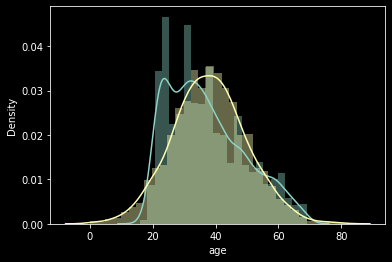

In [41]:
sns.distplot(data['age'])
sns.distplot(synth_df['age'])

In [42]:
params = parameter_learning(data, node_types, bn, 'mix')

save_structure(bn, 'socio_net_structure')
skel = read_structure('socio_net_structure')
save_params(params, 'socio_net_param')
params = read_params('socio_net_param')
socio_bn = HyBayesianNetwork(skel, params)

In [43]:
synth_df = generate_synthetics(socio_bn, node_sign, 'mix', 2000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

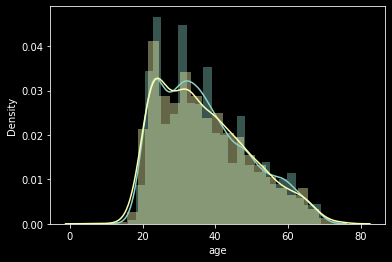

In [44]:
sns.distplot(data['age'])
sns.distplot(synth_df['age'])